In [1]:
from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike


import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import random as jrandom
import equinox as eqx

import optax


from functools import partial

from collections.abc import Generator
from typing_extensions import TypeAlias



from dataclasses import dataclass, asdict, astuple

In [2]:
print(jax.devices())


[CpuDevice(id=0)]


# Utils

In [3]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0

#class ModelState(eqx.Module):
#    S0: float
#    v0: float

class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())

In [4]:
import matplotlib.pyplot as plt

#def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
#    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
#    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')
#
#    print(init_spots.shape)
#    print(states.S0.shape)
#    # plt.plot(init_spots, states
#    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
#    plt.legend()
#    plt.xlabel('initial spot price')
#    plt.ylabel('payoff')
#    # plt.ylim(-1, 1000)
#    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("\nu_0")
    ax.set_zlabel(label)
    return fig


In [5]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))


In [6]:
def normalize(x, x_mean, x_std):
    return (x - x_mean) / x_std

# HVP stuff

In [7]:

# HVP for single point and single direction from Bachelier
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]

# from bachelier
def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))




# Payoff

In [ ]:
#class EuropeanPayoff:
#
#    # TODO: naming: strike_prices should be strike_price unless we would like to support an array of strike prices
#    @staticmethod
#    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
#        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)
#
#    @staticmethod
#    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
#        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)
#
#    @staticmethod
#    def payoff(spot_path, K, payoff_fn = call):
#        spot_maturity = spot_path[..., -1]
#        payoff = payoff_fn(spot_maturity, K)
#        return payoff
#
#
#def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
#    spot_maturity = spot_path[..., -1]
#    payoff = payoff_fn(spot_maturity, K)
#    return payoff
#
#def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
#    spot_maturity = spot_path[..., -1]
#    # payoff = payoff_fn(spot_maturity, K)
#    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
#    return payoff, dpayoff

In [ ]:
#sharpness = 1e-3
#bias = sharpness
#
#def smooth_european_payoff(x, k):
#    return jax.nn.celu(x=x-k, alpha=sharpness) + bias
#
#
#fn = lambda x: jax.nn.celu(x=x, alpha=sharpness) + bias
#smooth_max_fn = fn


In [114]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

k = 3
basket_dim = 7
pre_built_directions = jrandom.normal(subkey, shape=(k, basket_dim, 2))

print(pre_built_directions.shape)

(3, 7, 2)


# Heston

In [115]:
from typing import Final
#class ModelState(eqx.Module):
#    S0: float
#    v0: float

## just for testing
#class DDModelState(eqx.Module):
#    S0: ModelState
#    v0: ModelState

    
class Heston(eqx.Module):

    
    # for basket
    n_dims: Final[int]
    weights: Float[Array, " n_dims"]


    spot_range:Range = Range(50.0, 150.0)
    vol_range: Range = Range(0.01, 0.1)

    mc_time_steps: int = 1024 # number of time steps for the Monte Carlo simulation
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    # for semi-closed-form solution
    num_w: int = 512
    w_max: float = 100.0

    
    


    def closed_form_price(self, S0, v0):
        """
        Compute the Heston model European call price using the semi-closed-form solution using numerical integration in JAX.

        Math from:  https://www.ma.imperial.ac.uk/~ajacquie/IC_Num_Methods/IC_Num_Methods_Docs/Literature/Heston.pdf
        and form:   https://xilinx.github.io/Vitis_Libraries/quantitative_finance/2019.2/methods/cf-ht.html#chrso2014
        
        Parameters:
        - S0: initial spot price
        - v0: initial variance
       
        Returns:
        - call option price under Heston model
        """

        sigma = self.xi # volatility of volatility

        # integration grid
        w = jnp.linspace(0.0, self.w_max, self.num_w)[1:]  # avoid w=0

        # Heston characteristic function components
        a = self.kappa * self.theta
        def C_D(wi):
            alpha = -0.5 * wi**2 - 0.5j * wi
            beta  = alpha - 1j * self.rho * sigma * wi
            gamma = 0.5 * sigma**2

            h = jnp.sqrt(beta**2 - 4 * alpha * gamma)
            rp = (beta + h) / (sigma**2)
            rm = (beta - h) / (sigma**2)
            g = rm / rp

            exp_neg_ht = jnp.exp(-h * self.T)
            C = a * (rm * self.T - (2.0 / sigma**2) * jnp.log((1 - g * exp_neg_ht) / (1 - g)))
            D = rm * (1 - exp_neg_ht) / (1 - g * exp_neg_ht)
            return C, D

        # vectorize C and D over w
        C_vec, D_vec = jax.vmap(C_D)(w)

        # characteristic function Psi
        log_term = jnp.log(S0) + self.r * self.T
        def Psi(wi, Ci, Di):
            return jnp.exp(Ci * self.theta + Di * v0 + 1j * wi * log_term)

        Psi_w      = Psi(w,      C_vec, D_vec)
        Psi_w_minus_i = Psi(w - 1j, *jax.vmap(C_D)(w - 1j))
        Psi_minus_i = Psi(-1j, *C_D(-1j))

        # integrands for Pi1 and Pi2
        integrand1 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w_minus_i / (1j * w * Psi_minus_i))
        integrand2 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w      / (1j * w))

        # numerical integration via the trapezoidal rule
        Pi1 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand1, w)
        Pi2 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand2, w)

        # final price
        price = S0 * Pi1 - jnp.exp(-self.r * self.T) * self.K * Pi2
        return price
    

    def closed_form_basket_price(self, basket_S0s, basket_v0s):
        # vectorize single‐asset pricer over the basket axis
        prices = jax.vmap(self.closed_form_price)(basket_S0s, basket_v0s)
        return jnp.dot(self.weights, prices)
    

    def closed_form_basket_price_x(self, x_flat):
        d = self.n_dims
        S0s = x_flat[:d]        # first n_dims entries
        v0s = x_flat[d:]        # next n_dims entries
        return self.closed_form_basket_price(S0s, v0s)




    
    #def hessian_2x2_for_basket(self, S0s, v0s):
    #    
    #    
    #    hvps = hvp_batch(
    #        f=self.closed_form_basket_price_x,
    #        # NOTE this is where later the extra basket dim can be added
    #        inputs=jnp.array([(initial_spots, initial_vols)]), 
    #        directions=jnp.array([[1.0, 0.0], [0.0, 1.0]]) 
    #    )
    #    
    #    H_block = jnp.transpose(hvps[0], (1,0))
    #
    #    return H_block




    def sample_data_closed_form(self, key, n_samples=256):    
        

        key, subkey = jrandom.split(key)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        
        
        initial_states = jrandom.uniform(
            subkey, 
            shape=(n_samples, self.n_dims, 2), 
            minval=minvals, 
            maxval=maxvals
        ) # (batch, n_dims, 2)
        S0s = initial_states[..., 0]    # (batch, n_dims)
        v0s = initial_states[..., 1]     # (batch, n_dims)
    


        # # wrap the basket‐price fn so it matches vmap’s signature
        #def basket_fn(s_row, v_row):
        #    return self.closed_form_basket_price(s_row, v_row)


        value_and_grad_fn = jax.value_and_grad(self.closed_form_basket_price, argnums=(0,1))
        y, (dS0s, dV0s) = jax.vmap(value_and_grad_fn)(S0s, v0s)
        dydx = jnp.stack([dS0s, dV0s], axis=-1)
        # x:     (batch, n_dims, 2)
        # y:     (batch,)
        # dydx:  (batch, n_dims, 2)
        
        #print("x shape: ", initial_states.shape)
        #print("y shape: ", y.shape)
        #print("dydx shape: ", dydx.shape)




        initial_states_flat = initial_states.reshape(n_samples, 2*self.n_dims)  # (batch, 2*n_dims)


        k = 3
        key, subkey = jrandom.split(key)
        #rand_directions = jrandom.normal(subkey, shape=(k, self.n_dims, 2))
        #directions = rand_directions
        directions = pre_built_directions
        directions_flat = directions.reshape(k, 2*self.n_dims)  # (k, 2*n_dims)

        hvps_flat = hvp_batch(
            f=self.closed_form_basket_price_x,
            inputs=initial_states_flat, 
            directions=directions_flat 
        )# (batch_size, k, 2*n_dims) 
        
        hvps = hvps_flat.reshape(n_samples, k, self.n_dims, 2) 
        # (batch_size, k, n_dims, 2)

        ddyddx = hvps
        #print("ddyddx shape: ", ddyddx.shape)


        # NOTE
        # with basket now the shapes are:
        # x: (batch_size, n_dims, 2)
        # y: (batch_size, )
        # dydx: (batch_size, n_dims, 2)
        # ddyddx: (batch_size, k_probe_directions, n_dims, 2, 2)


        

        ##  TODO Normalize the data
        x_mean = jnp.mean(initial_states, axis=0)   # (basket, 2)
        x_std = jnp.std(initial_states, axis=0)     # (basket, 2)
        y_mean = jnp.mean(y)                        # scalar
        y_std = jnp.std(y)                          # scalar        
        
        x = normalize(initial_states, x_mean, x_std)
        y = normalize(y, y_mean, y_std)
        
        ## TODO understand why this is needed
        dydx_scaled = dydx * (x_std / y_std)[None, ...]
        
        ddyddx_scaled =  ddyddx * (x_std**2 / y_std)
        #
        #x = initial_states
        #return x, y, dydx_scaled, ddyddx_scaled



        x = initial_states
        x_flat = x.reshape(x.shape[0], -1)  # flatten the input
        return x_flat, y, dydx, ddyddx




test closed form

In [116]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

n_dims = 7 

ref_model = Heston(
    n_dims=n_dims,
    weights=jrandom.uniform(subkey, shape=(n_dims,), minval=1.0, maxval=10.0),
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

test closed form

In [117]:
batch = ref_model.sample_data_closed_form(key, n_samples=256)
print("batch shapes:", batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape)

batch shapes: (256, 14) (256,) (256, 7, 2) (256, 3, 7, 2)


In [118]:
closed_form_vis_batch = ref_model.sample_data_closed_form(key, n_samples=512)
test_set = ref_model.sample_data_closed_form(key, n_samples=512)
print("test_set shapes:", test_set[0].shape, test_set[1].shape, test_set[2].shape, test_set[3].shape)

test_set shapes: (512, 14) (512,) (512, 7, 2) (512, 3, 7, 2)


In [ ]:
# with basket the shapes are:
# x: (batch_size, n_dims, 2)
# y: (batch_size, )
# dydx: (batch_size, n_dims, 2)
# ddyddx: (batch_size, k_probe_directions, n_dims, 2, 2)


shapes after getting rid of the basket dimension:
x shape:  (512, 2)
y shape:  (512,)
dydx shape:  (512, 2)
ddyddx shape:  (512, 3, 2)


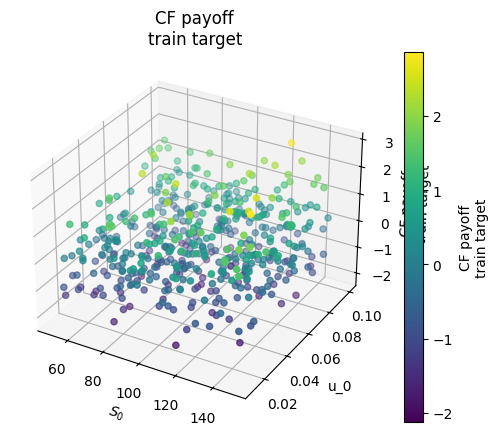

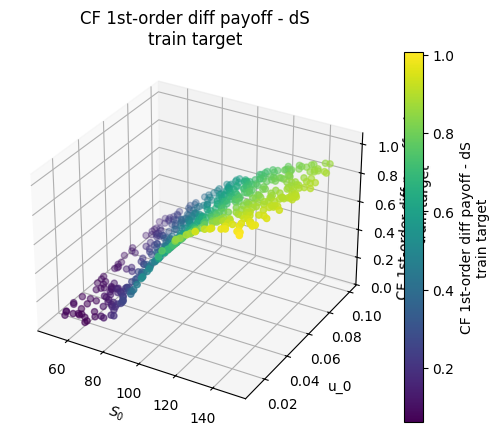

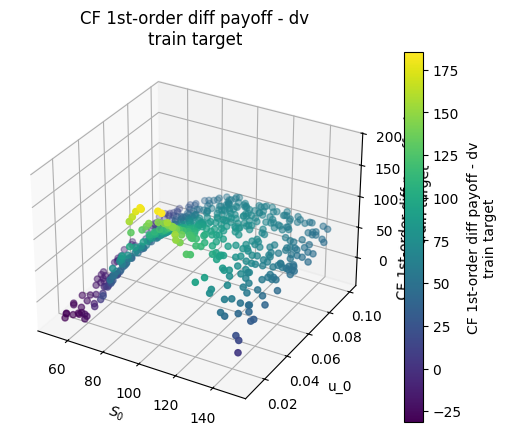

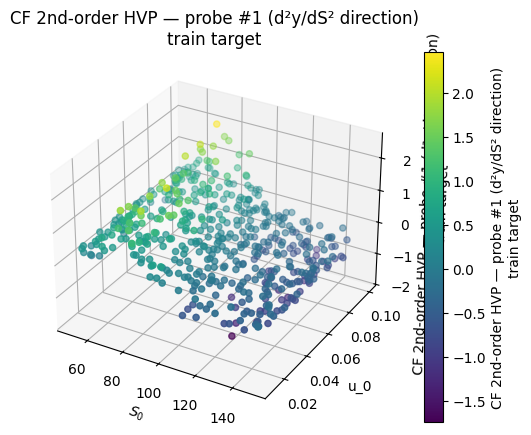

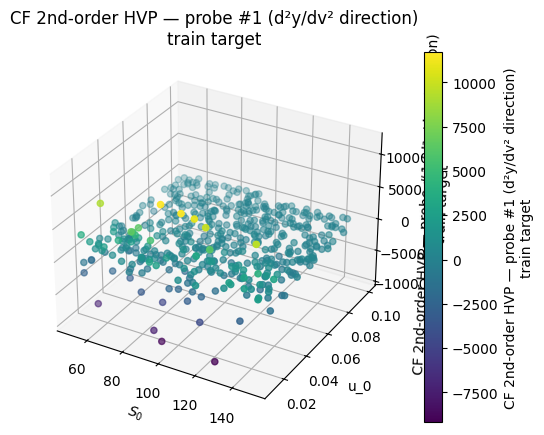

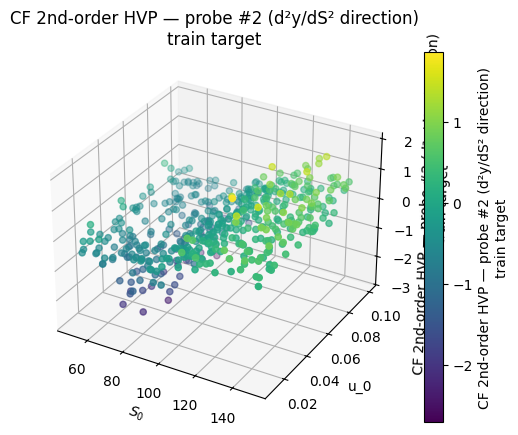

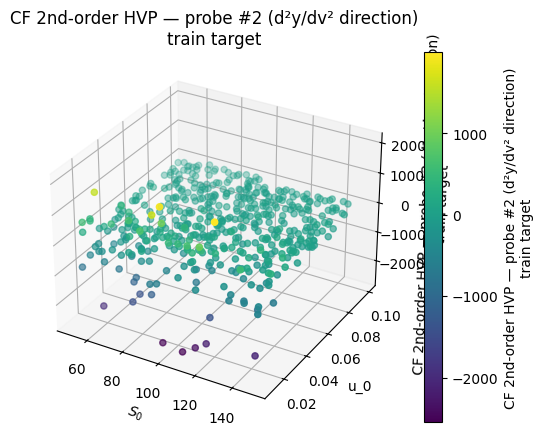

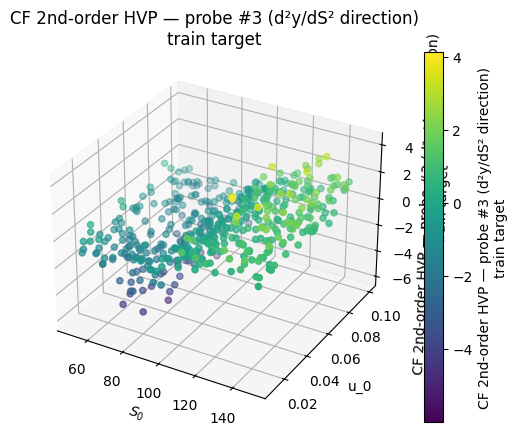

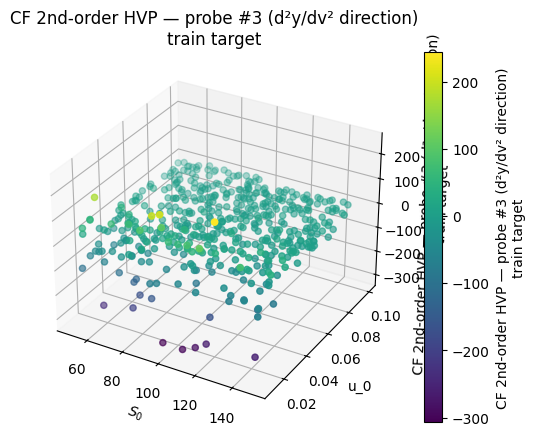

In [119]:

x, y, dydx, ddyddx = closed_form_vis_batch

x = x.reshape(512, 7, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
ddyddx = ddyddx[:, :, 0, :]  # (batch_size, k_probe_directions, 2, 2)

## average over the basket dimension
#x = x.mean(axis=1)
#y = y
#dydx = dydx.mean(axis=1) 
#ddyddx = ddyddx.mean(axis=2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




xs = x[..., 0]
ys = x[..., 1]


fig_payoff = plot_3d_differential_data(xs, ys, y, "CF payoff\ntrain target")

fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "CF 1st-order diff payoff - dS\ntrain target")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "CF 1st-order diff payoff - dv\ntrain target")




num_probes = ddyddx.shape[1]
for j in range(num_probes):
    # second‐order effect in the S0‐direction
    fig_ddS = plot_3d_differential_data(xs, ys, ddyddx[:, j, 0], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dS² direction)\ntrain target")
    # second‐order effect in the v0‐direction
    fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, j, 1], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dv² direction)\ntrain target")



# Learning

### Model

In [107]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

### Loss Functions

In [ ]:
def standard_loss_fn(model, batch):
    x = batch[0]
    #x = x.reshape(x.shape[0], -1)  # flatten the input
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)


@eqx.filter_jit
def second_order_loss_fn(model: eqx.nn.MLP, batch) -> Float:
    
    #batch = ref_model.sample_data(key, batch_size)
        
    x = batch[0]
    #x = x.reshape(x.shape[0], -1)  # flatten the input
    y = batch[1]
    dydx = batch[2]
    #ddyddx = batch[3]

    #print("x shape: ", x.shape)
    #print("y shape: ", y.shape)
    #print("dydx shape: ", dydx.shape)
    #print("ddyddx shape: ", ddyddx.shape)
    #print("")
    #return .0


    # TODO normalization ?
    #x = (x - x_mean) / x_std
    #y = (y - y_mean) / y_std
    
    # TODO loss balancing
    #lam = 1
    #n_dims = model.in_size
    #lambda_scale = lam * n_dims
    #alpha = 1.0/(1.0 + lambda_scale)
    #beta = lambda_scale/(1.0 + lambda_scale)
    #gamma = 0.0

    alpha = 1/3
    beta = 1/3
    gamma = 1/3
    
    #alpha = 0.2
    #beta = 0.6
    #gamma = 0.2

    
    
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)
    #assert(y_pred.shape == y.shape)
    #assert(dydx_pred.shape == dydx.shape)
    
    #print("y_pred shape: ", y_pred.shape)
    #print("dydx_pred shape: ", dydx_pred.shape)
    #print("")
    #return .0

    #ddyddx_pred = vmap(jax.hessian(MakeScalar(model)))(x)
    #assert(ddyddx_pred.shape == ddyddx.shape)
    
    #print("ddyddx_pred shape: ", ddyddx_pred.shape)
    #print("")
    #return .0



    value_loss = mse(y_pred, y)
    grad_loss = mse(dydx_pred, dydx.reshape(dydx.shape[0], -1)) 
    # TODO the reshaping and flattening is a huge source of errors

    
    #hess_loss = mse(ddyddx_pred, ddyddx)
    #hess_loss = 0


    #jax.debug.print("value loss: {}", value_loss)
    #jax.debug.print("grad loss: {}", grad_loss)
    #jax.debug.print("hess loss: {}", hess_loss)
    #jax.debug.print("---------------------------------")
    
    
    #loss = alpha * value_loss + beta * grad_loss + gamma * hess_loss
    
    loss = 0.5*value_loss + 0.5*grad_loss

    return loss




### Train

In [145]:
from itertools import islice

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
DataGenerator: TypeAlias = Generator[Data, None, None]


def train(
    model: PyTree,
    test_data: Tuple,
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int,
    batch_size: int,
    key: PRNGKeyArray,
) -> PyTree:
    

    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch_size: int):
        
        batch = ref_model.sample_data_closed_form(key, batch_size)

        #loss_value, grads = eqx.filter_value_and_grad(standard_loss_fn)(model, batch)
        loss_value, grads = eqx.filter_value_and_grad(second_order_loss_fn)(model, batch)
        
        
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps = n_epochs * n_batches_per_epoch
    print(f"Training for {n_epochs} epochs with {n_batches_per_epoch} batches per epoch and batch size {batch_size}.")
    
    keys = jrandom.split(key, n_steps)

    for i, key in enumerate(keys):
        
        
        # print(i)
        # print(batch["normalized_initial_states"])
        # print(batch["normalized_payoffs"].shape)
        with jax.profiler.StepTraceAnnotation("Train Step", step_num=i):  

            model, opt_state, train_loss = train_step(model, opt_state, batch_size)
        
        if i % n_batches_per_epoch == 0:
            epoch_stats = f"Finished epoch {int(i/n_batches_per_epoch)+1} | Train Loss: {train_loss:.5f}"    

            # test data evaluation
            if test_data:
                x_test_flat = test_data[0]#test_data[0].reshape(test_data[0].shape[0], -1)  # flatten the input
                
                
                test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(model))(x_test_flat)
                #test_pred_ddys = vmap(jax.hessian(MakeScalar(model)))(test_set[0])
                y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
                #dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
                #ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))
                test_loss = y_error # (y_error + dy_error + ddy_error) / 3.0
                epoch_stats += f" | Test Loss: {test_loss:.5f}"
            
            print(epoch_stats)

            
    return model

In [146]:
n_epochs = 100
n_batches_per_epoch = 32
BATCH_SIZE = 256
basket_dims = 7

# NOTE batch:_size * n_batches_per_epoch = 8192

key = jrandom.PRNGKey(0)

ref_model = Heston(
    n_dims=basket_dims,
    weights=jrandom.uniform(subkey, shape=(basket_dims,), minval=1.0, maxval=10.0),
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)


key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# in_size is 2 for initial_spot and initial_vol
input_dims = 2*basket_dims
mlp = eqx.nn.MLP(key=subkey, in_size=input_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)

key, subkey = jax.random.split(key)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp

#train_dataset = ds
#generator_train_ds = generator_train_data(train_dataset, batch_size=BATCH_SIZE)
#generator_test_ds = None
# total_steps = n_epochs * (len(ds["payoffs"]) // BATCH_SIZE) + n_epochs

# total_steps = 64 * n_epochs
# lr_schedule = optax.exponential_decay(init_value=0.01, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
# optim = optax.adam(learning_rate=lr_schedule)
optim = optax.adam(learning_rate=1e-3) # 3e-4 was default


surrogate_model = train(
                        model = surrogate_model, 
                        test_data=test_set,
                        optim=optim, 
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        batch_size=BATCH_SIZE,
                        key=key
                        )


Training for 100 epochs with 32 batches per epoch and batch size 256.
Finished epoch 1 | Train Loss: 35245.39844 | Test Loss: 37.94250
Finished epoch 2 | Train Loss: 34429.24219 | Test Loss: 6.43651
Finished epoch 3 | Train Loss: 34404.86328 | Test Loss: 3.02236
Finished epoch 4 | Train Loss: 34390.38672 | Test Loss: 2.76283
Finished epoch 5 | Train Loss: 34355.04297 | Test Loss: 2.67318
Finished epoch 6 | Train Loss: 34274.79297 | Test Loss: 2.47268
Finished epoch 7 | Train Loss: 34075.39453 | Test Loss: 2.75355
Finished epoch 8 | Train Loss: 33626.60156 | Test Loss: 4.56929
Finished epoch 9 | Train Loss: 32805.38281 | Test Loss: 6.33450
Finished epoch 10 | Train Loss: 31474.46094 | Test Loss: 6.63280
Finished epoch 11 | Train Loss: 29453.83789 | Test Loss: 7.08441
Finished epoch 12 | Train Loss: 26958.78320 | Test Loss: 13.49792
Finished epoch 13 | Train Loss: 24310.60352 | Test Loss: 23.06613
Finished epoch 14 | Train Loss: 21715.24219 | Test Loss: 11.40605
Finished epoch 15 | Train

In [147]:
# eval price predictions
test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(surrogate_model))(test_set[0])
#test_pred_ddys = vmap(jax.hessian(MakeScalar(surrogate_model)))(test_set[0])


In [148]:
directions = pre_built_directions
directions_flat = directions.reshape(k, 2*7)  # (k, 2*n_dims)
test_pred_ddys = hvps_flat = hvp_batch(
        f=MakeScalar(surrogate_model),
        inputs=test_set[0], 
        directions=directions_flat 
    )# (batch_size, k, 2*n_dims) 
        

In [149]:
y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2].reshape(test_set[2].shape[0], -1)))
ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3].reshape(test_set[3].shape[0], test_set[3].shape[1], -1)))

print(f"test y error: {y_error:.4f}")
print(f"test dy error: {dy_error:.4f}")
print(f"test ddy error: {ddy_error:.4f}")

test y error: 28.9536
test dy error: 178.8982
test ddy error: 3390.4419


In [ ]:
# standard loss fn:
# test y error: 
# test dy error: 
# test ddy error: 


# second order loss fn:
# test y error: 
# test dy error: 
# test ddy error: 

shapes after getting rid of the basket dimension:
x shape:  (512, 2)
y shape:  (512,)
dydx shape:  (512, 2)
ddyddx shape:  (512, 3, 2)


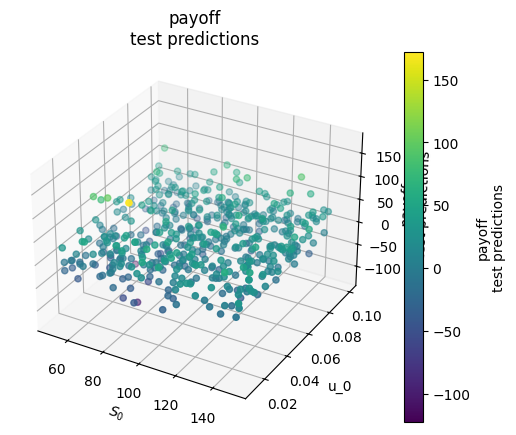

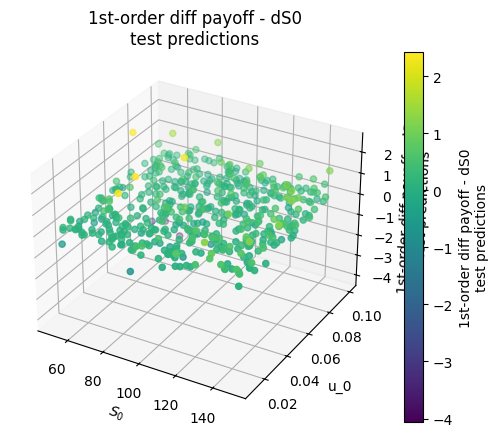

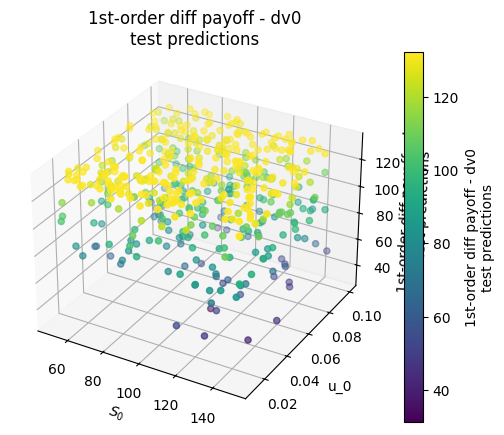

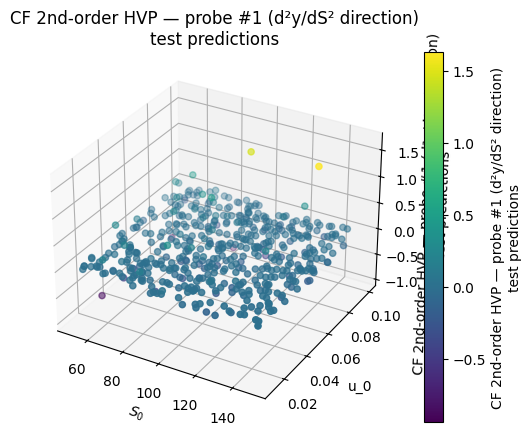

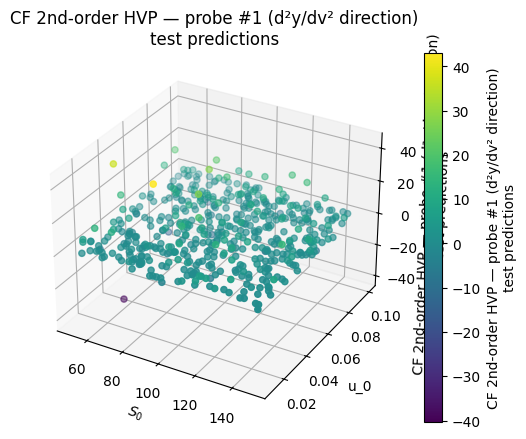

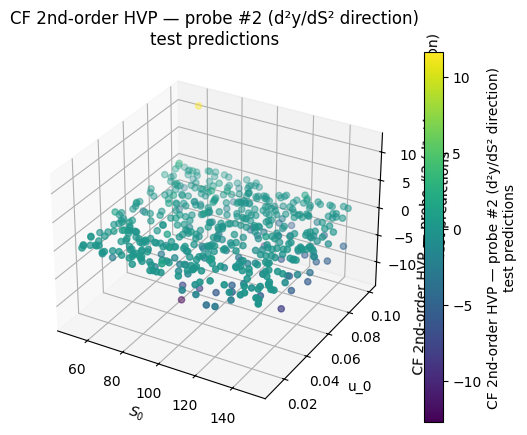

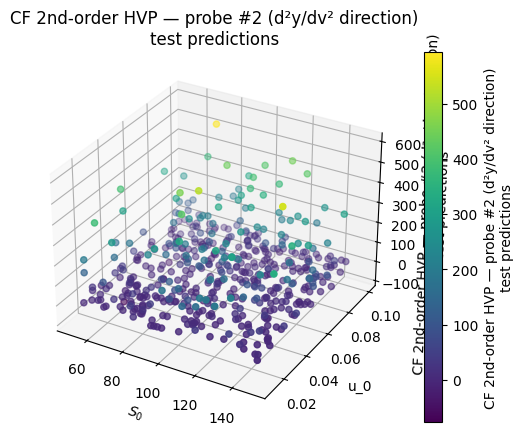

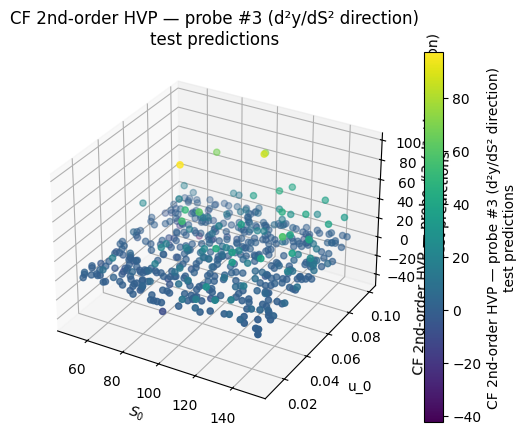

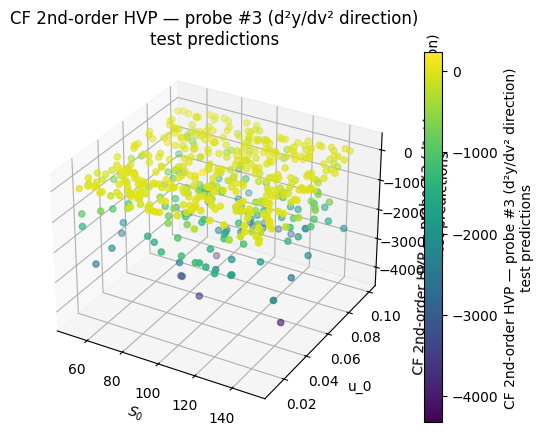

In [150]:
x = test_set[0]

y = test_pred_ys
dydx = test_pred_dys
ddyddx = test_pred_ddys


x = x.reshape(512, 7, 2)
dydx = dydx.reshape(512, 7, 2)
ddyddx = ddyddx.reshape(512, k, 7, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
ddyddx = ddyddx[:, :, 0, :]  # (batch_size, k_probe_directions, 2, 2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




# plot the predictions
xs = x[..., 0]
ys = x[..., 1]



fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest predictions")



fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv0\ntest predictions")

num_probes = ddyddx.shape[1]
for j in range(num_probes):
    # second‐order effect in the S0‐direction
    fig_ddS = plot_3d_differential_data(xs, ys, ddyddx[:, j, 0], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dS² direction)\ntest predictions")
    # second‐order effect in the v0‐direction
    fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, j, 1], f"CF 2nd‐order HVP — probe #{j+1} (d²y/dv² direction)\ntest predictions")
